# FastFlow
This notebook demonstrates how to train/deploy FastFlow model.

## Imports


In [1]:

from functools import partial, update_wrapper
from torch.optim import Optimizer
from types import MethodType
from typing import Any, Optional
from pytorch_lightning import Trainer, LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

from anomalib.data.mvtec import MVTec
from anomalib.models.fastflow.lightning_model import Fastflow
from anomalib.utils.callbacks import (
    MetricsConfigurationCallback,
    MinMaxNormalizationCallback,
    VisualizerCallback,
)
from torch.optim.adam import Adam
from pytorch_lightning.utilities.types import LRSchedulerType, LRSchedulerTypeTuple, LRSchedulerTypeUnion
from torchvision.transforms import ToPILImage

## Data Module
To train the model end-to-end, we do need to have a dataset. In our [previous notebooks](https://github.com/openvinotoolkit/anomalib/tree/development/notebooks/100_datamodules), we demonstrate how to initialize benchmark and custom datasets. In this tutorial, we will use MVTec AD DataModule. We assume that `datasets` directory is created in the `anomalib` root directory and `MVTec` dataset is located in `datasets` directory.

In [2]:
datamodule = MVTec(
    root="../../datasets/MVTec/",
    category="bottle",
    image_size=256,
    train_batch_size=32,
    test_batch_size=32,
    num_workers=8,
    task="segmentation",
)
datamodule.setup()
i, data = next(enumerate(datamodule.test_dataloader()))
print(f'Image Shape: {data["image"].shape}\n Mask Shape: {data["mask"].shape}')

Image Shape: torch.Size([32, 3, 256, 256])
 Mask Shape: torch.Size([32, 256, 256])


## Models
Now that we have created MVTec datamodule, we could create the models. We could start with `PatchCore` since it is the ranked #1 model on the MVTec AD category on papers with code. 

Each model on anomalib has the following structure:
```
        anomalib/models/<model_name>
        ├── README.md           # Readme file containing description and benchmarks.
        ├── __init__.py         # Model initialization.
        ├── config.yaml         # Stores the model configurations.  
        ├── torch_model.py      # Torch model implementing the basic forward-pass mechanism.
        ├── anomaly_map.py      # [Optional] module generating anomaly heatmaps.      
        ├── lightning_model.py  # Lightning module implementing training mechanism
        └── loss.py             # [Optional] module implementing loss computation. 
```



In [ ]:
Fastflow??

In [ ]:
model = Fastflow(input_size=[256, 256], backbone="resnet18", flow_steps=8)

In [4]:
model.training = True
train_output = model(data["image"])
hidden_variables, log_jacobian = train_output
print(f'Hidden Variable Shape: {hidden_variables[0].shape}')

Hidden Variable Shape: torch.Size([32, 64, 64, 64])


As can be seen above, the Lightning Module also returns the same output as `torch_model`. This is because it stores `torch_model` as its attribute and uses it in its `forward` method. Therefore, it is possible to call the forward-pass with `model(x)`. For the implementational details, you could refer to [this](https://github.com/openvinotoolkit/anomalib/blob/development/anomalib/models/components/base/anomaly_module.py#L64) link. 

In [5]:
model.model.training = False
anomaly_map = model(data["image"])
print(f'Anomaly Map Shape: {anomaly_map.shape}')

Anomaly Map Shape: torch.Size([32, 1, 256, 256])


## Optimizer
`LightningModule` has `configure_optimizer` method that returns the optimizer object. This is not implemented in Anomalib model. Instead, it is left to the user to make it configurable by either CLI or API.

In [6]:
def configure_optimizers(lightning_module: LightningModule, optimizer: Optimizer) -> Any:
    """Override to customize the :meth:`~pytorch_lightning.core.lightning.LightningModule.configure_optimizers`
    method.

    Args:
        lightning_module: A reference to the model.
        optimizer: The optimizer.
    """
    return optimizer        

optimizer = Adam(params=model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=1e-5)    
fn = partial(configure_optimizers, optimizer=optimizer)
update_wrapper(fn, configure_optimizers)  # necessary for `is_overridden`
model.configure_optimizers = MethodType(fn, model)


## Training
Now that we see how anomalib models are structured, we could try to train a model. In order to properly train the models we need to set number of callbacks such as model saving and early stopping.

Let's create these callbacks.

## Callbacks
To train the model properly, we will to add some other "non-essential" logic such as saving the weights, early-stopping, normalizing the anomaly scores and visualizing the input/output images. To achieve these we use `Callbacks`. Anomalib has its own callbacks and also supports PyTorch Lightning's native callbacks. So, let's create the list of callbacks we want to execute during the training.

In [7]:
callbacks = [
    MetricsConfigurationCallback(
        adaptive_threshold=True,
        image_metric_names=["AUROC"],
        pixel_metric_names=["AUROC"],
    ),
    ModelCheckpoint(
        mode="max",
        monitor="pixel_AUROC",
    ),
    EarlyStopping(
        monitor="pixel_AUROC",
        mode="max",
        patience=3,
    ),
    MinMaxNormalizationCallback(),
    VisualizerCallback(task="segmentation", log_images_to=["local"]),
]

The final component that we need to train a model is `pytorch_lightning` `Trainer` object, which handles train/test/predict pipeline. Let's create the trainer object to train the model.

In [8]:
trainer = Trainer(
    callbacks=callbacks,
    accelerator="auto", # <"cpu", "gpu", "tpu", "ipu", "hpu", "auto">,
    devices=1,
    max_epochs=100,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


`Trainer` object has number of options that suit all specific needs. For more details, refer to [Lightning Documentation](https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html) to see how it could be tweaked to your needs.

Let's train the model now.

In [9]:
trainer.fit(datamodule=datamodule, model=model)

/home/sakcay/miniconda3/envs/anomalib/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                  | Type                     | Params
-------------------------------------------------------------------
0 | image_threshold       | AdaptiveThreshold        | 0     
1 | pixel_threshold       | AdaptiveThreshold        | 0     
2 | training_distribution | AnomalyScoreDistribution | 0     
3 | min_max               | MinMax                   | 0     
4 | model                 | FastflowModel            | 7.7 M 
5 | loss                  | FastflowLoss             | 0     
6 | image_metrics         | AnomalibMetricCollection | 0     
7 | pixel_metrics         | AnomalibMetricCollection | 0     
------------------------------------------------------

/home/sakcay/miniconda3/envs/anomalib/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/home/sakcay/miniconda3/envs/anomalib/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: T

Epoch 14: 100%|██████████| 10/10 [03:06<00:00, 18.69s/it, loss=-5.01e+05, v_num=6, pixel_AUROC=0.973]


In [12]:
trainer.test(datamodule=datamodule, model=model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing DataLoader 0: 100%|██████████| 3/3 [00:24<00:00,  8.03s/it]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9968253970146179     │
│        pixel_AUROC        │    0.9712699055671692     │
└───────────────────────────┴───────────────────────────┘

[{'pixel_AUROC': 0.9712699055671692, 'image_AUROC': 0.9968253970146179}]

In [13]:
predictions = trainer.predict(model=model, datamodule=datamodule)[0]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting DataLoader 0: 100%|██████████| 212/212 [00:25<00:00,  7.93it/s] 


In [14]:
print(predictions.keys())

dict_keys(['image', 'anomaly_maps', 'pred_scores', 'pred_labels', 'pred_masks'])


In [15]:
predictions['image'].shape

torch.Size([32, 3, 256, 256])

In [16]:
index = 10

In [23]:
image = predictions['image'][index]
anomaly_map = predictions['anomaly_maps'][index]
pred_score = predictions['pred_scores'][index]
pred_labels = predictions['pred_labels'][index]
pred_masks = predictions['pred_masks'][index]

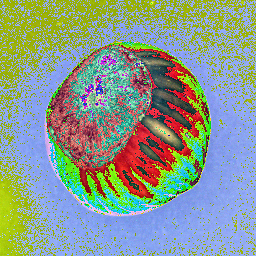

In [20]:
ToPILImage()(image)

In [21]:
from anomalib.pre_processing.transforms import Denormalize

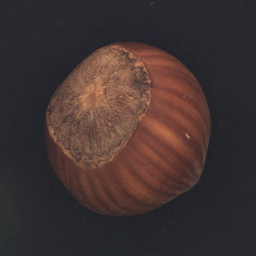

In [22]:
ToPILImage()(Denormalize()(image))

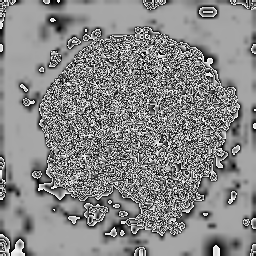

In [26]:
ToPILImage()(anomaly_map*255)

In [25]:
anomaly_map

tensor([[[0.9631, 0.9631, 0.9650,  ..., 0.9554, 0.9511, 0.9511],
         [0.9631, 0.9631, 0.9650,  ..., 0.9554, 0.9511, 0.9511],
         [0.9606, 0.9606, 0.9631,  ..., 0.9574, 0.9534, 0.9534],
         ...,
         [0.9573, 0.9573, 0.9618,  ..., 0.9899, 0.9889, 0.9889],
         [0.9553, 0.9553, 0.9600,  ..., 0.9894, 0.9884, 0.9884],
         [0.9553, 0.9553, 0.9600,  ..., 0.9894, 0.9884, 0.9884]]])